In [ ]:
# default_exp modeling.token_classification

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.token_classification

> This module contains custom models, loss functions, custom splitters, etc... for token classification tasks like named entity recognition.

In [ ]:
#export
import ast, torch
from transformers import *
from fastai.text.all import *

from blurr.utils import *
from blurr.data.core import *
from blurr.data.token_classification import *
from blurr.modeling.core import *

from seqeval import metrics as seq_metrics

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.0
Using fastai 2.1.5
Using transformers 3.4.0


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Token classification

The objective of token classification is to predict the correct label for each token provided in the input. In the computer vision world, this is akin to what we do in segmentation tasks whereby we attempt to predict the class/label for each pixel in an image. Named entity recognition (NER) is an example of token classification in the NLP space

In [ ]:
# ensures these cols are represented as lists (rather than string)
df_converters = {'tokens': ast.literal_eval, 'labels': ast.literal_eval, 'nested-labels': ast.literal_eval}

# full nlp dataset
# germ_eval_df = pd.read_csv('./data/task-token-classification/germeval2014ner_cleaned.csv', converters=df_converters)

# demo nlp dataset
germ_eval_df = pd.read_csv('./germeval2014_sample.csv', converters=df_converters)

print(len(germ_eval_df))
germ_eval_df.head()

1000


,id,source,tokens,labels,nested-labels,ds_type
0,0,n-tv.de vom 26.02.2005 [2005-02-26],"[Schartau, sagte, dem, "", Tagesspiegel, "", vom, Freitag, ,, Fischer, sei, "", in, einer, Weise, aufgetreten, ,, die, alles, andere, als, überzeugend, war, "", .]","[B-PER, O, O, O, B-ORG, O, O, O, O, B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
1,1,welt.de vom 29.10.2005 [2005-10-29],"[Firmengründer, Wolf, Peter, Bree, arbeitete, Anfang, der, siebziger, Jahre, als, Möbelvertreter, ,, als, er, einen, fliegenden, Händler, aus, dem, Libanon, traf, .]","[O, B-PER, I-PER, I-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
2,2,http://www.stern.de/sport/fussball/krawalle-in-der-fussball-bundesliga-dfb-setzt-auf-falsche-konzepte-1553657.html#utm_source=standard&utm_medium=rss-feed&utm_campaign=sport [2010-03-25],"[Ob, sie, dabei, nach, dem, Runden, Tisch, am, 23., April, in, Berlin, durch, ein, pädagogisches, Konzept, unterstützt, wird, ,, ist, allerdings, zu, bezweifeln, .]","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train
3,3,stern.de vom 21.03.2006 [2006-03-21],"[Bayern, München, ist, wieder, alleiniger, Top-, Favorit, auf, den, Gewinn, der, deutschen, Fußball-Meisterschaft, .]","[B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, B-LOCderiv, O, O]","[B-LOC, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O]",train
4,4,http://www.fr-online.de/in_und_ausland/sport/aktuell/1618625_Frings-schaut-finster-in-die-Zukunft.html [2008-10-24],"[Dabei, hätte, der, tapfere, Schlussmann, allen, Grund, gehabt, ,, sich, viel, früher, aufzuregen, .]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",train


We are only going to be working with small sample from the [GermEval 2014](https://sites.google.com/site/germeval2014ner/data) data set ... so the results might not be all that great :).

In [ ]:
labels = sorted(list(set([lbls for sublist in germ_eval_df.labels.tolist() for lbls in sublist])))
print(labels)

['B-LOC', 'B-LOCderiv', 'B-LOCpart', 'B-ORG', 'B-ORGpart', 'B-OTH', 'B-OTHderiv', 'B-OTHpart', 'B-PER', 'B-PERderiv', 'B-PERpart', 'I-LOC', 'I-LOCderiv', 'I-ORG', 'I-ORGpart', 'I-OTH', 'I-PER', 'O']


In [ ]:
task = HF_TASKS_AUTO.TokenClassification
pretrained_model_name = "bert-base-multilingual-cased"
config = AutoConfig.from_pretrained(pretrained_model_name)

config.num_labels = len(labels)

Notice above how I set the `config.num_labels` attribute to the number of labels we want *our* model to be able to predict. The model will update its last layer accordingly (this concept is essentially transfer learning).

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bert',
 transformers.configuration_bert.BertConfig,
 transformers.tokenization_bert.BertTokenizer,
 transformers.modeling_bert.BertForTokenClassification)

In [ ]:
test_eq(hf_config.num_labels, len(labels))

In [ ]:
before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_tokenizer, is_split_into_words=True, 
                                                     tok_kwargs={ 'return_special_tokens_mask': True })

blocks = (
    HF_TextBlock(before_batch_tfms=before_batch_tfm, input_return_type=HF_TokenClassInput), 
    HF_TokenCategoryBlock(vocab=labels)
)

def get_y(inp):
    return [ (label, len(hf_tokenizer.tokenize(str(entity)))) for entity, label in zip(inp.tokens, inp.labels) ]

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('tokens'),
                   get_y=get_y,
                   splitter=RandomSplitter())

We have to define a `get_y` that creates the same number of labels as there are subtokens for a particular token. For example, my name "Wayde" gets split up into two subtokens, "Way" and "##de". The label for "Wayde" is "B-PER" and we just repeat it for the subtokens.  This all get cleaned up when we show results and get predictions.

In [ ]:
dls = dblock.dataloaders(germ_eval_df, bs=2)

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,token / target label
0,"[('Helbig', 'B-OTH'), ('et', 'I-OTH'), ('al', 'I-OTH'), ('.', 'O'), ('(', 'O'), ('1994', 'O'), (')', 'O'), ('S', 'O'), ('.', 'O'), ('593', 'B-OTH'), ('.', 'I-OTH'), ('Wink', 'I-OTH'), ('&', 'I-OTH'), ('Seibold', 'I-OTH'), ('et', 'O'), ('al', 'O'), ('.', 'O'), ('(', 'O'), ('1998', 'O'), (')', 'O'), ('S', 'O'), ('.', 'O'), ('32', 'O'), ('Inwieweit', 'O'), ('noch', 'O'), ('andere', 'O'), ('Falken', 'O'), (',', 'B-LOCderiv'), ('wie', 'O'), ('der', 'O'), ('Afrikanische', 'O'), ('Baumfalke', 'O'), ('(', 'O'), ('Falco', 'O'), ('cuvieri', 'O'), (')', 'O'), ('oder', 'O'), ('der', 'O'), ('Malaienbaumfalke', 'O'), ('(', 'O'), ('Falco', 'O'), ('serverus', 'O'), (')', 'O'), ('dieser', 'O'), ('Gruppe', 'O'), ('zuzuzählen', 'O'), ('sind', 'O'), (',', 'O'), ('ist', 'O'), ('Gegenstand', 'O')]"
1,"[('Scenes', 'B-OTH'), ('of', 'I-OTH'), ('a', 'I-OTH'), ('Sexual', 'I-OTH'), ('Nature', 'I-OTH'), ('(', 'O'), ('GB', 'O'), ('2006', 'O'), (')', 'O'), ('-', 'O'), ('Regie', 'O'), (':', 'O'), ('Ed', 'B-PER'), ('Blum', 'I-PER'), ('Shortbus', 'B-OTH'), ('(', 'O'), ('USA', 'B-LOC'), ('2006', 'O'), (')', 'O'), ('-', 'O'), ('Regie', 'O'), (':', 'O'), ('John', 'B-PER'), ('Cameron', 'I-PER'), ('Mitchell', 'I-PER'), (':', 'O'), ('Film', 'O'), ('über', 'O'), ('den', 'O'), ('gleichnamigen', 'B-LOCderiv'), ('New', 'I-LOCderiv'), ('Yorker', 'O'), ('Club', 'O'), (',', 'O'), ('der', 'O'), ('verschiedensten', 'O'), ('Paaren', 'O'), ('eine', 'O'), ('Plattform', 'O'), ('zur', 'O'), ('Aufarbeitung', 'O'), ('ihrer', 'O'), ('Probleme', 'O'), ('bietet', 'O')]"


### Metrics

In this section, we'll add helpful metrics for token classification tasks

In [ ]:
#export
def calculate_token_class_metrics(pred_toks, targ_toks, metric_key):
    if (metric_key == 'accuracy'): return seq_metrics.accuracy_score(targ_toks, pred_toks)
    if (metric_key == 'precision'): return seq_metrics.precision_score(targ_toks, pred_toks)
    if (metric_key == 'recall'): return seq_metrics.recall_score(targ_toks, pred_toks)
    if (metric_key == 'f1'): return seq_metrics.f1_score(targ_toks, pred_toks)
        
    if (metric_key == 'classification_report'): return seq_metrics.classification_report(targ_toks, pred_toks)
        

### Training

In [ ]:
#export
class HF_TokenClassCallback(HF_BaseModelCallback):
    """A fastai friendly callback that includes accuracy, precision, recall, and f1 metrics using the
    `seqeval` library.  Additionally, this metric knows how to *not* include your 'ignore_token' in it's
    calculations.
    
    See [here](https://github.com/chakki-works/seqeval) for more information on `seqeval`.
    """
    def __init__(self, tok_metrics=["accuracy", "precision", "recall", "f1"], **kwargs):
        self.run_before = Recorder
        
        store_attr(self=self, names='tok_metrics, kwargs')
        self.custom_metrics_dict = { k:None for k in tok_metrics }
        
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return
        
        # grab the hf_tokenizer from the target's HF_TokenizerTransform (used for rouge metrics)
        hf_textblock_tfm = self.dls.before_batch[0]
        self.hf_tokenizer = hf_textblock_tfm.hf_tokenizer
        self.ignore_label_token_id = self.dls.tfms[1].ignore_token_id
        self.tok_special_symbols = list(self.hf_tokenizer.special_tokens_map.values())
        self.tok_kwargs = hf_textblock_tfm.kwargs
        
        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics
        self.learn.token_classification_report = None
        
        self.do_setup = False
        
    def before_fit(self): self.setup()
    
    
    # --- batch begin/after phases ---
    def after_batch(self):
        if (self.training or self.learn.y is None): return
        
        # do this only for validation set
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0] # yb is TensorText tuple, item 0 is the data
        
        preds_list, targets_list = [], []   
        for i in range(targs.shape[0]):
            item_targs, item_preds = [], []
            
            for j in range(targs.shape[1]):
                if (targs[i, j] != self.ignore_label_token_id):
                    item_preds.append(self.dls.vocab[preds[i][j].item()])
                    item_targs.append(self.dls.vocab[targs[i][j].item()])
                    
            preds_list.append(item_preds)
            targets_list.append(item_targs)
            
        self.results += [ (res[0], res[1]) for res in zip(preds_list, targets_list) ]
        
        
    # --- validation begin/after phases ---
    def before_validate(self): self.results = []
        
    def after_validate(self):
        if (len(self.results) < 1): return
        
        preds, targs = map(list, zip(*self.results))
        for k in self.custom_metrics_dict.keys(): 
            self.custom_metrics_dict[k] = calculate_token_class_metrics(targs, preds, metric_key=k)
        
        try:
            self.learn.token_classification_report = calculate_token_class_metrics(targs, 
                                                                                   preds, 
                                                                                   'classification_report')
        except ZeroDivisionError as err:
            print(f'Couldn\'t calcualte classification report: {err}')
        
        
    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                cbs=[HF_TokenClassCallback],
                splitter=hf_splitter)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.blurr_summary()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0].shape

(1, torch.Size([2, 76, 18]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 76]), 2, torch.Size([2, 76]))

In [ ]:
print(preds[0].view(-1, preds[0].shape[-1]).shape, b[1].view(-1).shape)
test_eq(preds[0].view(-1, preds[0].shape[-1]).shape[0], b[1].view(-1).shape[0])

torch.Size([152, 18]) torch.Size([152])


In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=3.630780702224001e-05)

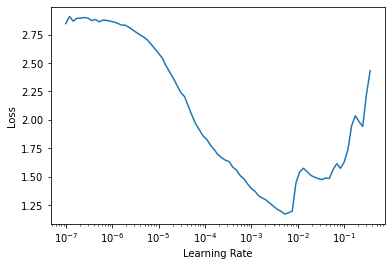

In [ ]:
#slow
learn.unfreeze()
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max= 3e-5, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.209931,0.159975,0.952798,0.580087,0.498141,0.536000,00:36
1,0.124946,0.108146,0.968178,0.658009,0.716981,0.686230,00:37
2,0.066819,0.100261,0.971891,0.722944,0.673387,0.697286,00:37


In [ ]:
#slow
print(learn.token_classification_report)

           precision    recall  f1-score   support

      ORG       0.68      0.49      0.57        51
      PER       0.95      0.86      0.90        64
      LOC       0.79      0.78      0.79        73
  LOCpart       0.20      1.00      0.33         1
      OTH       0.32      0.32      0.32        31
 LOCderiv       0.89      0.68      0.77        25
  ORGpart       0.33      0.67      0.44         3

micro avg       0.72      0.67      0.70       248
macro avg       0.75      0.67      0.71       248



### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(x:HF_TokenClassInput, y:HF_TokenTensorCategory, samples, outs, learner, 
                 ctxs=None, max_n=6, trunc_at=None, **kwargs):    
    # grab tokenizer
    hf_textblock_tfm = learner.dls.before_batch[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    
    res = L()
    for inp, trg, sample, pred in zip(x, y, samples, outs):
        # recontstruct the string and split on space to get back your pre-tokenized list of tokens
        toks = hf_tokenizer.convert_ids_to_tokens(inp, skip_special_tokens=True)
        pretokenized_toks =  hf_tokenizer.convert_tokens_to_string(toks).split()
        
        # get predictions for subtokens that aren't ignored (e.g. special toks and token parts)
        pred_labels = [ pred_lbl for lbl_id, pred_lbl in zip(trg, ast.literal_eval(pred[0])) if lbl_id != -100 ]
        
        trg_labels = ast.literal_eval(sample[1])
        res.append([f'{[ (tok, trg, pred) for idx, (tok, pred, trg) in enumerate(zip(pretokenized_toks, pred_labels, trg_labels)) if (trunc_at is None or idx < trunc_at) ]}'])
        
    display_df(pd.DataFrame(res, columns=['token / target label / predicted label'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=10)

,token / target label / predicted label
0,"[('Nach', 'O', 'O'), ('seiner', 'O', 'O'), ('Rückkehr', 'O', 'O'), ('hielt', 'O', 'O'), ('Strummer', 'B-PER', 'B-PER'), ('ein', 'O', 'O'), ('Bandmeeting', 'O', 'O'), ('ab', 'O', 'O'), (',', 'O', 'O'), ('in', 'O', 'O')]"
1,"[('Erstmals', 'O', 'O'), ('Urkundlich', 'O', 'O'), ('erwähnt', 'O', 'O'), ('ist', 'O', 'O'), ('Nimburg', 'B-LOC', 'B-PER'), ('bereits', 'O', 'O'), ('im', 'O', 'O'), ('Jahre', 'O', 'O'), ('977', 'O', 'O'), ('.', 'O', 'O')]"


In [ ]:
res = learn.blurr_predict('My name is Wayde and I live in San Diego'.split())
print(res[0])

['O', 'O', 'O', 'O', 'B-PER', 'B-PER', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'O']


The default `Learner.predict` method returns a prediction per subtoken, including the special tokens for each architecture's tokenizer.

In [ ]:
#export
@patch
def blurr_predict_tokens(self:Learner, inp, **kargs):
    """Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
    get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input
    """
    pred_lbls, pred_lbl_ids, probs = self.blurr_predict(inp)

    # grab the huggingface tokenizer from the learner's dls.tfms
    hf_textblock_tfm = self.dls.before_batch[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    tok_kwargs = hf_textblock_tfm.tok_kwargs
    
    # calculate the number of subtokens per raw/input token so that we can determine what predictions to
    # return
    subtoks_per_raw_tok = [ (entity, len(hf_tokenizer.tokenize(str(entity)))) for entity in inp ]
    
    # very similar to what HF_BatchTransform does with the exception that we are also grabbing
    # the `special_tokens_mask` to help with getting rid or irelevant predicts for any special tokens
    # (e.g., [CLS], [SEP], etc...)
    res = hf_tokenizer(inp, None, 
                       max_length=hf_textblock_tfm.max_length,
                       padding=hf_textblock_tfm.padding,
                       truncation=hf_textblock_tfm.truncation,
                       is_split_into_words=hf_textblock_tfm.is_split_into_words,
                       **tok_kwargs)

    special_toks_msk = L(res['special_tokens_mask'])
    actual_tok_idxs = special_toks_msk.argwhere(lambda el: el != 1)
    
    # using the indexes to the actual tokens, get that info from the results returned above
    pred_lbls_list = ast.literal_eval(pred_lbls)
    actual_pred_lbls = L(pred_lbls_list)[actual_tok_idxs]
    actual_pred_lbl_ids = pred_lbl_ids[actual_tok_idxs]
    actual_probs = probs[actual_tok_idxs]
    
    # now, because a raw token can be mapped to multiple subtokens, we need to build a list of indexes composed
    # of the *first* subtoken used to represent each raw token (that is where the prediction is)
    offset = 0
    raw_trg_idxs = []
    for idx, (raw_tok, sub_tok_count) in enumerate(subtoks_per_raw_tok): 
        raw_trg_idxs.append(idx+offset)
        offset += sub_tok_count-1 if (sub_tok_count > 1) else 0

    return inp, actual_pred_lbls[raw_trg_idxs], actual_pred_lbl_ids[raw_trg_idxs], actual_probs[raw_trg_idxs]

In [ ]:
show_doc(Learner.blurr_predict_tokens)

<h4 id="Learner.blurr_predict_tokens" class="doc_header"><code>Learner.blurr_predict_tokens</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.blurr_predict_tokens</code>(**`inp`**, **\*\*`kargs`**)

Remove all the unnecessary predicted tokens after calling `Learner.predict`, so that you only
get the predicted labels, label ids, and probabilities for what you passed into it in addition to the input

In [ ]:
txt ="Hi! My name is Wayde Gilliam from ohmeow.com. I live in California."

In [ ]:
res = learn.blurr_predict_tokens(txt.split())
print([(tok, lbl) for tok,lbl in zip(res[0],res[1])])

[('Hi!', 'O'), ('My', 'O'), ('name', 'O'), ('is', 'O'), ('Wayde', 'B-PER'), ('Gilliam', 'I-PER'), ('from', 'O'), ('ohmeow.com.', 'B-ORG'), ('I', 'O'), ('live', 'O'), ('in', 'O'), ('California.', 'B-LOC')]


It's interesting (and very cool) how well this model performs on English even thought it was trained against a German corpus.

## Tests

The tests below to ensure the token classification training code above works for **all** pretrained token classification models available in huggingface.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained token classification models you are working with ... and if any of your pretrained token classification models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
BLURR_MODEL_HELPER.get_models(task='TokenClassification')

[transformers.modeling_albert.AlbertForTokenClassification,
 transformers.modeling_auto.AutoModelForTokenClassification,
 transformers.modeling_bert.BertForTokenClassification,
 transformers.modeling_camembert.CamembertForTokenClassification,
 transformers.modeling_distilbert.DistilBertForTokenClassification,
 transformers.modeling_electra.ElectraForTokenClassification,
 transformers.modeling_flaubert.FlaubertForTokenClassification,
 transformers.modeling_funnel.FunnelForTokenClassification,
 transformers.modeling_layoutlm.LayoutLMForTokenClassification,
 transformers.modeling_longformer.LongformerForTokenClassification,
 transformers.modeling_mobilebert.MobileBertForTokenClassification,
 transformers.modeling_roberta.RobertaForTokenClassification,
 transformers.modeling_squeezebert.SqueezeBertForTokenClassification,
 transformers.modeling_xlm.XLMForTokenClassification,
 transformers.modeling_xlm_roberta.XLMRobertaForTokenClassification,
 transformers.modeling_xlnet.XLNetForTokenClassi

In [ ]:
pretrained_model_names = [
    'albert-base-v1',
    'bert-base-multilingual-cased',
    'camembert-base',
    'distilbert-base-uncased',
    #'<electra>', # currently no pre-trained electra model works for token classification
    'allenai/longformer-base-4096',
    'google/mobilebert-uncased',
    'roberta-base',
    'xlm-mlm-ende-1024',
    'xlm-roberta-base',
    'xlnet-base-cased'
]

In [ ]:
#slow
#hide_output
task = HF_TASKS_AUTO.TokenClassification
bsz = 2
seq_sz = 32

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    config = AutoConfig.from_pretrained(model_name)
    config.num_labels = len(labels)
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(model_name, 
                                                                                   task=task, 
                                                                                   config=config)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\n')
    
    before_batch_tfm = HF_TokenClassBeforeBatchTransform(hf_arch, hf_tokenizer, 
                                                         max_length=seq_sz,
                                                         padding='max_length',
                                                         is_split_into_words=True, 
                                                         tok_kwargs={ 'return_special_tokens_mask': True })

    blocks = (
        HF_TextBlock(before_batch_tfms=before_batch_tfm, input_return_type=HF_TokenClassInput), 
        HF_TokenCategoryBlock(vocab=labels)
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader('tokens'),
                       get_y= lambda inp: [ 
                           (label, len(hf_tokenizer.tokenize(str(entity)))) 
                           for entity, label in zip(inp.tokens, inp.labels) 
                       ],
                       splitter=RandomSplitter())
    
    dls = dblock.dataloaders(germ_eval_df, bs=bsz)

    model = HF_BaseModelWrapper(hf_model)
    learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                cbs=[HF_TokenClassCallback],
                splitter=hf_splitter)

    learn.create_opt()             # -> will create your layer groups based on your "splitter" function
    learn.unfreeze()
    
    b = dls.one_batch()
    
    try:
        print('*** TESTING DataLoaders ***')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, seq_sz]))
        test_eq(len(b[1]), bsz)

        print('*** TESTING One pass through the model ***')
        preds = learn.model(b[0])
        test_eq(len(preds[0]), bsz)
        test_eq(preds[0].shape, torch.Size([bsz, seq_sz, len(labels)]))

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max= 3e-5, moms=(0.8,0.7,0.8))

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, trunc_at=10)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== albert-base-v1 ===

architecture:	albert
tokenizer:	AlbertTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.397884,0.334202,0.924774,0.228571,0.625000,0.334728,00:19


,token / target label / predicted label
0,"[('auerdem', 'O', 'O'), ('befindet', 'O', 'O'), ('sich', 'O', 'O'), ('im', 'O', 'O'), ('nordwesten', 'O', 'O'), ('der', 'O', 'O'), ('stadt', 'O', 'O'), ('(', 'O', 'O'), ('auf', 'O', 'O'), ('dem', 'O', 'O')]"
1,"[('berg', 'B-PER', 'B-LOC'), ('spricht', 'O', 'O'), ('hier', 'O', 'O'), ('als', 'O', 'O'), ('chef', 'O', 'O'), ('von', 'O', 'O'), ('microsoft', 'B-ORG', 'O'), ('deutschland', 'I-ORG', 'O'), ('auch', 'O', 'O'), ('fur', 'O', 'O')]"


=== bert-base-multilingual-cased ===

architecture:	bert
tokenizer:	BertTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.188294,0.198280,0.949709,0.611354,0.654206,0.632054,00:37


,token / target label / predicted label
0,"[('Helbig', 'B-OTH', 'I-PER'), ('et', 'I-OTH', 'O'), ('al', 'I-OTH', 'I-PER'), ('.', 'O', 'O'), ('(', 'O', 'O'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('S', 'O', 'O'), ('.', 'O', 'O'), ('593', 'B-OTH', 'I-PER')]"
1,"[('Außerdem', 'O', 'O'), ('befindet', 'O', 'O'), ('sich', 'O', 'O'), ('im', 'O', 'O'), ('Nordwesten', 'O', 'O'), ('der', 'O', 'O'), ('Stadt', 'O', 'O'), ('(', 'O', 'O'), ('auf', 'O', 'O'), ('dem', 'O', 'O')]"


=== camembert-base ===

architecture:	camembert
tokenizer:	CamembertTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.835932,0.812578,0.899955,0.000000,0,0,00:33


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


,token / target label / predicted label
0,"[('NEWSru.ua', 'B-OTH', 'O'), ('/', 'O', 'O'), (':', 'O', 'O'), ('ооо', 'B-OTH', 'O'), ('оаа', 'I-OTH', 'O'), ('оо', 'I-OTH', 'O')]"
1,"[('Nachdem', 'O', 'O'), ('die', 'O', 'O'), ('Einwohnerzahl', 'O', 'O'), ('in', 'O', 'O'), ('der', 'O', 'O'), ('ersten', 'O', 'O'), ('Hlfte', 'O', 'O'), ('des', 'O', 'O'), ('20.', 'O', 'O'), ('Jahrhu', 'O', 'O')]"


=== distilbert-base-uncased ===

architecture:	distilbert
tokenizer:	DistilBertTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.307468,0.326979,0.920641,0.251337,0.297468,0.272464,00:20


,token / target label / predicted label
0,"[('(', 'O', 'O'), ('standard', 'B-ORG', 'B-ORG'), ('oil', 'I-ORG', 'B-ORG'), ('of', 'I-ORG', 'O'), ('new', 'I-ORG', 'I-PER'), ('jersey', 'I-ORG', 'B-LOC'), (')', 'O', 'O'), (',', 'O', 'O'), ('die', 'O', 'O'), ('ausgesprochen', 'O', 'O')]"
1,"[('scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'O'), ('sexual', 'I-OTH', 'O'), ('nature', 'I-OTH', 'O'), ('(', 'O', 'O'), ('gb', 'O', 'O'), ('2006', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O')]"


=== allenai/longformer-base-4096 ===

architecture:	longformer
tokenizer:	LongformerTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.366306,0.355079,0.911318,0.143678,0.257732,0.184502,02:04


,token / target label / predicted label
0,"[('Scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'O'), ('Sexual', 'I-OTH', 'O'), ('Nature', 'I-OTH', 'O'), ('(', 'O', 'O'), ('GB', 'O', 'O'), ('2006', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O')]"
1,"[('NEWSru.ua', 'B-OTH', 'O'), ('/', 'O', 'O'), (':', 'O', 'O'), ('Политисполком', 'B-OTH', 'O'), ('СПУ', 'I-OTH', 'O'), ('от', 'I-OTH', 'O')]"


=== google/mobilebert-uncased ===

architecture:	mobilebert
tokenizer:	MobileBertTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.675269,0.603670,0.873559,0.000000,0.000000,0,02:09


,token / target label / predicted label
0,"[('helbig', 'B-OTH', 'O'), ('et', 'I-OTH', 'B-LOC'), ('al', 'I-OTH', 'B-LOC'), ('.', 'O', 'B-ORG'), ('(', 'O', 'O'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('s', 'O', 'I-LOCderiv'), ('.', 'O', 'I-LOCderiv'), ('593', 'B-OTH', 'B-ORG')]"
1,"[('zugang', 'O', 'O'), ('und', 'O', 'O'), ('engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('netz', 'O', 'O')]"


=== roberta-base ===

architecture:	roberta
tokenizer:	RobertaTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.370285,0.360035,0.911419,0.080247,0.216667,0.117117,00:33


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


,token / target label / predicted label
0,"[('(', 'O', 'O'), ('Standard', 'B-ORG', 'O'), ('Oil', 'I-ORG', 'O'), ('of', 'I-ORG', 'O'), ('New', 'I-ORG', 'O'), ('Jersey', 'I-ORG', 'O'), (')', 'O', 'O'), (',', 'O', 'O'), ('die', 'O', 'O'), ('ausgesprochen', 'O', 'O')]"
1,"[('Zugang', 'O', 'O'), ('und', 'O', 'O'), ('Engagement', 'O', 'O'), (':', 'O', 'O'), ('das', 'O', 'O'), ('eigentlich', 'O', 'O'), ('Neue', 'O', 'O'), ('an', 'O', 'O'), ('der', 'O', 'O'), ('Netz(', 'O', 'O')]"


=== xlm-mlm-ende-1024 ===

architecture:	xlm
tokenizer:	XLMTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.514749,0.563311,0.896833,0.000000,0,0,00:30


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


,token / target label / predicted label
0,"[('scenes', 'B-OTH', 'O'), ('of', 'I-OTH', 'O'), ('a', 'I-OTH', 'O'), ('sexual', 'I-OTH', 'O'), ('nature', 'I-OTH', 'O'), ('(', 'O', 'O'), ('gb', 'O', 'O'), ('2006', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O')]"
1,"[('newsru.ua', 'B-OTH', 'O'), ('/', 'O', 'O'), (':', 'O', 'O'), ('политисполком', 'B-OTH', 'O'), ('спу', 'I-OTH', 'O'), ('отказал', 'I-OTH', 'O'), ('м', 'I-OTH', 'O')]"


=== xlm-roberta-base ===

architecture:	xlm_roberta
tokenizer:	XLMRobertaTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.280242,0.223893,0.940957,0.480000,0.532020,0.504673,00:50


,token / target label / predicted label
0,"[('Helbig', 'B-OTH', 'I-PER'), ('et', 'I-OTH', 'O'), ('al', 'I-OTH', 'O'), ('.', 'O', 'O'), ('(', 'O', 'O'), ('1994', 'O', 'O'), (')', 'O', 'O'), ('S.', 'O', 'O'), ('593.', 'O', 'O'), ('Wink', 'B-OTH', 'I-PER')]"
1,"[('Genaugenommen', 'O', 'O'), ('gibt', 'O', 'O'), ('es', 'O', 'O'), ('aber', 'O', 'O'), ('den', 'O', 'O'), ('Migrationshintergrund', 'O', 'O'), ('nicht', 'O', 'O'), (',', 'O', 'O'), ('sondern', 'O', 'O'), ('nur', 'O', 'O')]"


=== xlnet-base-cased ===



/home/wgilliam/anaconda3/envs/blurr/lib/python3.7/site-packages/transformers/configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,


architecture:	xlnet
tokenizer:	XLNetTokenizer

*** TESTING DataLoaders ***
*** TESTING One pass through the model ***
*** TESTING Training/Results ***


epoch,train_loss,valid_loss,accuracy,precision,recall,f1,time
0,0.440073,0.343047,0.917049,0.057325,0.183673,0.087379,00:41


Couldn't calcualte classification report: Weights sum to zero, can't be normalized


,token / target label / predicted label
0,"[('Nach', 'O', 'O'), ('seiner', 'O', 'O'), ('Ruckkehr', 'O', 'O'), ('hielt', 'O', 'O'), ('Strummer', 'B-PER', 'O'), ('ein', 'O', 'O'), ('Bandmeeting', 'O', 'O'), ('ab', 'O', 'O'), (',', 'O', 'O'), ('in', 'O', 'O')]"
1,"[('Die', 'O', 'O'), ('Flugel', 'O', 'O'), ('Die', 'O', 'O'), ('geoffneten', 'O', 'O'), ('Flugel', 'O', 'O'), ('zeigen', 'O', 'O'), ('in', 'O', 'O'), ('vier', 'O', 'O'), ('Szenen', 'O', 'O'), ('Hohepunkte', 'O', 'O')]"


In [ ]:
#slow
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,albert,AlbertTokenizer,AlbertForTokenClassification,PASSED,
1,bert,BertTokenizer,BertForTokenClassification,PASSED,
2,camembert,CamembertTokenizer,CamembertForTokenClassification,PASSED,
3,distilbert,DistilBertTokenizer,DistilBertForTokenClassification,PASSED,
4,longformer,LongformerTokenizer,LongformerForTokenClassification,PASSED,
5,mobilebert,MobileBertTokenizer,MobileBertForTokenClassification,PASSED,
6,roberta,RobertaTokenizer,RobertaForTokenClassification,PASSED,
7,xlm,XLMTokenizer,XLMForTokenClassification,PASSED,
8,xlm_roberta,XLMRobertaTokenizer,XLMRobertaForTokenClassification,PASSED,
9,xlnet,XLNetTokenizer,XLNetForTokenClassification,PASSED,


## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-token-classification.ipynb.
Converted 01b_data-question-answering.ipynb.
Converted 01za_data-text2text-core.ipynb.
Converted 01zb_data-text2text-language-modeling.ipynb.
Converted 01zc_data-text2text-summarization.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-token-classification.ipynb.
Converted 02b_modeling-question-answering.ipynb.
Converted 02za_modeling-text2text-core.ipynb.
Converted 02zb_modeling-text2text-language-modeling.ipynb.
Converted 02zc_modeling-text2text-summarization.ipynb.
Converted 99a_examples-multilabel.ipynb.
Converted index.ipynb.
